In [11]:
import pandas as pd

df = pd.read_csv(
    "../data/raw/GPS tracking of guanay cormorants.csv",
    sep=","
)

print(df.columns)
print(df.head(10))
print(df["timestamp"].head(10))
print(df["timestamp"].dtype)

Index(['event-id', 'visible', 'timestamp', 'location-long', 'location-lat',
       'sensor-type', 'individual-taxon-canonical-name',
       'tag-local-identifier', 'individual-local-identifier', 'study-name'],
      dtype='object')
      event-id  visible                timestamp  location-long  location-lat  \
0  38034332770     True  2019-11-18 12:41:00.000     -78.963133     -8.532700   
1  38034332774     True  2019-11-18 12:44:00.000     -78.963183     -8.532567   
2  38034332777     True  2019-11-18 12:46:00.000     -78.943783     -8.529333   
3  38034332787     True  2019-11-18 12:53:00.000     -78.929550     -8.538633   
4  38034332792     True  2019-11-18 12:56:00.000     -78.907583     -8.539950   
5  38034332795     True  2019-11-18 12:58:00.000     -78.891933     -8.538983   
6  38034332798     True  2019-11-18 13:00:00.000     -78.875517     -8.536033   
7  38034332803     True  2019-11-18 13:02:00.000     -78.860233     -8.536967   
8  38034332808     True  2019-11-18 13:

In [15]:
import pandas as pd
import numpy as np

# 1. 读取数据
df = pd.read_csv(
    "../data/raw/GPS tracking of guanay cormorants.csv"
)

# 2. 时间转 datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 3. 按个体 + 时间排序
df = df.sort_values(
    ["individual-local-identifier", "timestamp"]
).reset_index(drop=True)

# 4. 计算时间差（秒）
df["dt"] = (
    df.groupby("individual-local-identifier")["timestamp"]
      .diff()
      .dt.total_seconds()
)

# 5. Haversine 距离函数
R = 6_371_000  # meters

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(
        np.radians, [lat1, lon1, lat2, lon2]
    )
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# 6. 计算相邻点距离
df["dist"] = haversine(
    df["location-lat"],
    df["location-long"],
    df.groupby("individual-local-identifier")["location-lat"].shift(-1),
    df.groupby("individual-local-identifier")["location-long"].shift(-1),
)

# 7. 速度（m/s）
df["speed"] = df["dist"] / df["dt"]

# 8. 查看结果
df[[
    "individual-local-identifier",
    "timestamp",
    "dt",
    "dist",
    "speed"
]].head(10)

,individual-local-identifier,timestamp,dt,dist,speed
0,G05GUCO_09_20181126-070802,2018-11-23 13:01:28,NaN,22.266993,NaN
1,G05GUCO_09_20181126-070802,2018-11-23 13:02:32,64.0,8.673204,0.135519
2,G05GUCO_09_20181126-070802,2018-11-23 13:03:37,65.0,19.359392,0.297837
3,G05GUCO_09_20181126-070802,2018-11-23 13:04:41,64.0,30.508582,0.476697
4,G05GUCO_09_20181126-070802,2018-11-23 13:05:46,65.0,22.683482,0.348977
5,G05GUCO_09_20181126-070802,2018-11-23 13:06:50,64.0,118.993584,1.859275
6,G05GUCO_09_20181126-070802,2018-11-23 13:08:42,112.0,118.913145,1.061725
7,G05GUCO_09_20181126-070802,2018-11-23 13:09:51,69.0,22.399109,0.324625
8,G05GUCO_09_20181126-070802,2018-11-23 13:10:55,64.0,42.300255,0.660941
9,G05GUCO_09_20181126-070802,2018-11-23 13:11:59,64.0,20.222781,0.315981


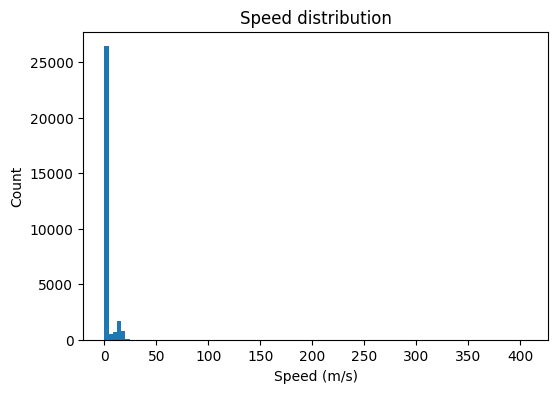

In [17]:
import matplotlib.pyplot as plt

df_valid = df[df["speed"].notna() & (df["dt"] > 0)]

plt.figure(figsize=(6,4))
plt.hist(df_valid["speed"], bins=100)
plt.xlabel("Speed (m/s)")
plt.ylabel("Count")
plt.title("Speed distribution")
plt.show()

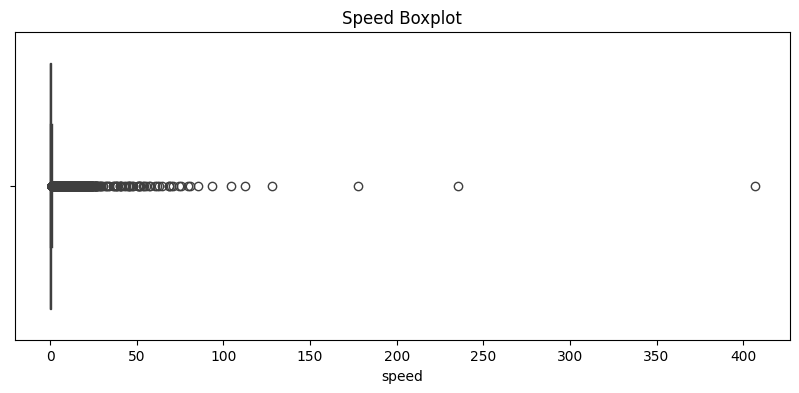

In [18]:
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.boxplot(x=df_valid["speed"])
plt.title("Speed Boxplot")
plt.show()

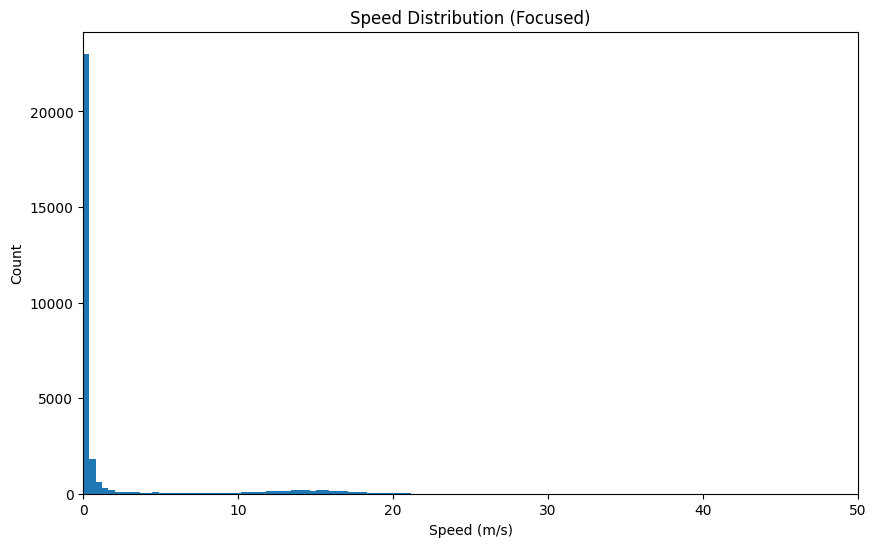

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(df_valid["speed"], bins=1000)
# 关键：设置 x 轴显示的范围
plt.xlim(0, 50) 
plt.xlabel("Speed (m/s)")
plt.ylabel("Count")
plt.title("Speed Distribution (Focused)")
plt.show()

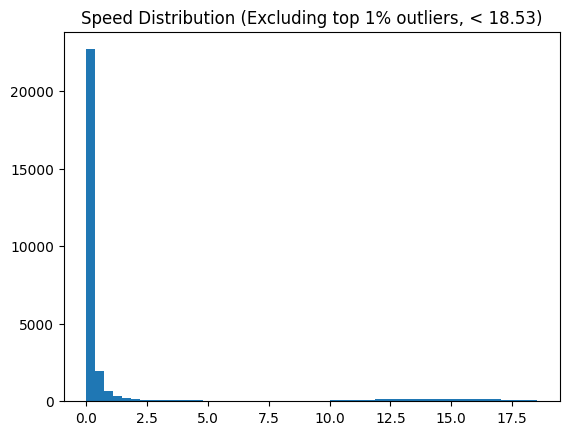

In [20]:
# 剔除 99% 分位数以上的数据
upper_limit = df_valid["speed"].quantile(0.99)
df_filtered = df_valid[df_valid["speed"] < upper_limit]

plt.hist(df_filtered["speed"], bins=50)
plt.title(f"Speed Distribution (Excluding top 1% outliers, < {upper_limit:.2f})")
plt.show()

In [21]:
# 生成行为标签
V0 = 2.5  # 先用 1.0，后面可调整

df_valid["behavior"] = (df_valid["speed"] >= V0).astype(int)

df_valid[[
    "timestamp",
    "speed",
    "behavior"
]].head(10)

/var/folders/t_/3syzgqzs0ks00djblwkt76dc0000gn/T/ipykernel_74088/1176074309.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["behavior"] = (df_valid["speed"] >= V0).astype(int)


,timestamp,speed,behavior
1,2018-11-23 13:02:32,0.135519,0
2,2018-11-23 13:03:37,0.297837,0
3,2018-11-23 13:04:41,0.476697,0
4,2018-11-23 13:05:46,0.348977,0
5,2018-11-23 13:06:50,1.859275,0
6,2018-11-23 13:08:42,1.061725,0
7,2018-11-23 13:09:51,0.324625,0
8,2018-11-23 13:10:55,0.660941,0
9,2018-11-23 13:11:59,0.315981,0
10,2018-11-23 13:13:04,0.415150,0


In [22]:
df_valid["behavior"] = (
    (df_valid["speed"] >= 2.5) &
    (df_valid["dt"] <= 120)     # 避免长 dt 平均造成的假中速
).astype(int)

/var/folders/t_/3syzgqzs0ks00djblwkt76dc0000gn/T/ipykernel_74088/709197461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["behavior"] = (


Behavior definition:
- flying (1): speed ≥ 2.5 m/s
- resting (0): speed < 2.5 m/s

V0 = 2.5 m/s，这是一个高 precision、低 recall的标签。
后面选择时间序列作为预测。


# Temporal train/test split (NO LEAKAGE)

In [23]:
def temporal_split_by_individual(df, time_col="timestamp", frac=0.7):
    train_parts = []
    test_parts = []

    for ind, g in df.groupby("individual-local-identifier"):
        g = g.sort_values(time_col)
        split_idx = int(len(g) * frac)
        train_parts.append(g.iloc[:split_idx])
        test_parts.append(g.iloc[split_idx:])

    train = pd.concat(train_parts).reset_index(drop=True)
    test  = pd.concat(test_parts).reset_index(drop=True)
    return train, test

train_df, test_df = temporal_split_by_individual(df_valid, frac=0.7)

print(len(train_df), len(test_df))

21145 9073


In [24]:
# Check
assert train_df["timestamp"].max() < test_df["timestamp"].max()
print("Train behavior counts:")
print(train_df["behavior"].value_counts())

print("\nTest behavior counts:")
print(test_df["behavior"].value_counts())

train_ratio = train_df["behavior"].mean()
test_ratio  = test_df["behavior"].mean()

print("Train flying ratio:", train_ratio)
print("Test  flying ratio:", test_ratio)

Train behavior counts:
behavior
0    18861
1     2284
Name: count, dtype: int64

Test behavior counts:
behavior
0    8070
1    1003
Name: count, dtype: int64
Train flying ratio: 0.10801607945140695
Test  flying ratio: 0.11054777912487601


## Skylearn

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    confusion_matrix, classification_report
)

features = ["speed", "dist", "dt"]
target = "behavior"

X_train = train_df[features].values
y_train = train_df[target].values

X_test  = test_df[features].values
y_test  = test_df[target].values

In [26]:
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z  = scaler.transform(X_test)

In [27]:
clf = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="liblinear",
    class_weight="balanced",
    max_iter=2000,
    random_state=42
)

clf.fit(X_train_z, y_train)

/Users/chuan_sugar/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multicl

In [28]:
y_prob = clf.predict_proba(X_test_z)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cm  = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("ROC-AUC:", auc)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n",
      classification_report(y_test, y_pred, digits=3))

Accuracy: 0.9939380579742092
ROC-AUC: 0.9995882241750584
Confusion matrix:
 [[8046   24]
 [  31  972]]

Classification report:
               precision    recall  f1-score   support

           0      0.996     0.997     0.997      8070
           1      0.976     0.969     0.972      1003

    accuracy                          0.994      9073
   macro avg      0.986     0.983     0.985      9073
weighted avg      0.994     0.994     0.994      9073



In [29]:
coef = clf.coef_[0]

for f, c in zip(features, coef):
    print(f"{f:>10s}: {c:+.3f}")

     speed: +21.042
      dist: -10.224
        dt: +0.013


## 重新建模
精度过高，去掉speed重新建模
新的特征集合
X = [dist, dt]
dist: 位移大小
dt: 时间间隔

In [30]:
features_nospeed = ["dist", "dt"]

X_train = train_df[features_nospeed].values
y_train = train_df["behavior"].values

X_test  = test_df[features_nospeed].values
y_test  = test_df["behavior"].values

In [31]:
# fit on train
from sklearn.preprocessing import StandardScaler

scaler_ns = StandardScaler()
X_train_z = scaler_ns.fit_transform(X_train)
X_test_z  = scaler_ns.transform(X_test)

In [32]:
from sklearn.linear_model import LogisticRegression

clf_ns = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="liblinear",
    class_weight="balanced",
    max_iter=2000,
    random_state=42
)

clf_ns.fit(X_train_z, y_train)

/Users/chuan_sugar/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multicl

In [33]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

y_prob_ns = clf_ns.predict_proba(X_test_z)[:, 1]
y_pred_ns = (y_prob_ns >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_ns))
print("ROC-AUC :", roc_auc_score(y_test, y_prob_ns))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_ns))
print("\nReport:\n", classification_report(y_test, y_pred_ns, digits=3))

Accuracy: 0.9684779014658877
ROC-AUC : 0.9803638650343888
Confusion matrix:
 [[7867  203]
 [  83  920]]

Report:
               precision    recall  f1-score   support

           0      0.990     0.975     0.982      8070
           1      0.819     0.917     0.865      1003

    accuracy                          0.968      9073
   macro avg      0.904     0.946     0.924      9073
weighted avg      0.971     0.968     0.969      9073



In [34]:
coef = clf_ns.coef_[0]
for f, c in zip(features_nospeed, coef):
    print(f"{f:>6s}: {c:+.3f}")

  dist: +3.048
    dt: -23.820


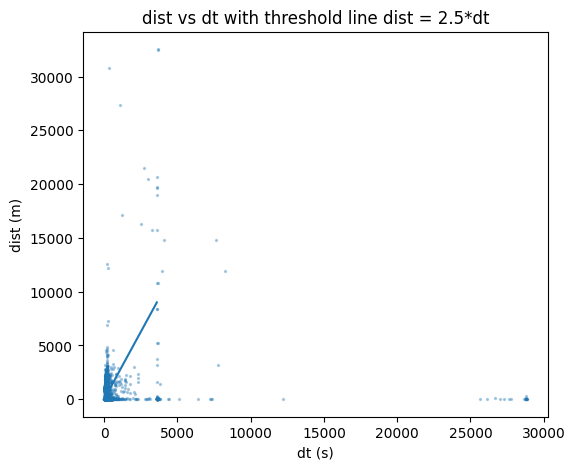

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 用 test 集合画，更像“验收”
g = test_df.copy()
g = g[g["dt"].notna() & g["dist"].notna() & (g["dt"] > 0)]

plt.figure(figsize=(6,5))
plt.scatter(g["dt"], g["dist"], s=2, alpha=0.3)
t = np.linspace(g["dt"].min(), g["dt"].quantile(0.99), 200)
plt.plot(t, 2.5*t)  # 阈值线：dist = 2.5*dt
plt.xlabel("dt (s)")
plt.ylabel("dist (m)")
plt.title("dist vs dt with threshold line dist = 2.5*dt")
plt.show()

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def train_eval(single_feature):
    Xtr = train_df[[single_feature]].values
    Xte = test_df[[single_feature]].values
    ytr = train_df["behavior"].values
    yte = test_df["behavior"].values

    sc = StandardScaler()
    Xtrz = sc.fit_transform(Xtr)
    Xtez = sc.transform(Xte)

    m = LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=2000, random_state=42)
    m.fit(Xtrz, ytr)
    p = m.predict_proba(Xtez)[:,1]
    return roc_auc_score(yte, p)

print("AUC(dist only):", train_eval("dist"))
print("AUC(dt only)  :", train_eval("dt"))

AUC(dist only): 0.9704596248429433
AUC(dt only)  : 0.5271142582166759


In [37]:
k = 5
df2 = df_valid.copy()
df2 = df2.sort_values(["individual-local-identifier","timestamp"])

# rolling mean speed within each individual
df2["speed_mean_k"] = (
    df2.groupby("individual-local-identifier")["speed"]
       .rolling(k, min_periods=k)
       .mean()
       .reset_index(level=0, drop=True)
)

# new segment label
V0 = 2.5
df2 = df2[df2["speed_mean_k"].notna()].copy()
df2["behavior_seg"] = (df2["speed_mean_k"] >= V0).astype(int)

print(df2["behavior_seg"].value_counts(normalize=True))

behavior_seg
0    0.838217
1    0.161783
Name: proportion, dtype: float64


## HMM


In [38]:
import numpy as np
import pandas as pd

eps = 1e-3

df_hmm = df_valid.copy()
df_hmm = df_hmm[df_hmm["speed"].notna() & df_hmm["dt"].notna() & (df_hmm["dt"] > 0)].copy()

# 可选：过滤极端 dt（长缺测会把行为变得奇怪）
df_hmm = df_hmm[(df_hmm["dt"] >= 30) & (df_hmm["dt"] <= 6*3600)].copy()

df_hmm["x"] = np.log(df_hmm["speed"] + eps)

# 按个体+时间排序
df_hmm = df_hmm.sort_values(["individual-local-identifier", "timestamp"]).reset_index(drop=True)

In [39]:
train_hmm, test_hmm = temporal_split_by_individual(df_hmm, time_col="timestamp", frac=0.7)

In [40]:
from hmmlearn.hmm import GaussianHMM

def to_X_lengths(df, col="x"):
    X_list = []
    lengths = []
    for ind, g in df.groupby("individual-local-identifier"):
        x = g[col].to_numpy().reshape(-1, 1)
        if len(x) < 10:
            continue  # 太短的序列跳过
        X_list.append(x)
        lengths.append(len(x))
    X = np.vstack(X_list)
    return X, lengths

X_train, lengths_train = to_X_lengths(train_hmm, col="x")
X_test, lengths_test   = to_X_lengths(test_hmm,  col="x")

In [41]:
hmm = GaussianHMM(
    n_components=2,         # 2 hidden states: rest vs flight
    covariance_type="diag", # 1维其实无所谓；diag最稳
    n_iter=200,
    random_state=42
)

hmm.fit(X_train, lengths_train)
print("Train log-likelihood:", hmm.score(X_train, lengths_train))

Train log-likelihood: -35581.6449081345


In [42]:
z_test = hmm.predict(X_test, lengths_test)   # Viterbi states

In [43]:
state_means = hmm.means_.flatten()
print("State means (log-speed):", state_means)

# 约定：均值更大的状态 = flight_state
flight_state = int(np.argmax(state_means))
rest_state   = 1 - flight_state

print("flight_state:", flight_state, "rest_state:", rest_state)

State means (log-speed): [-2.3177624   2.54063187]
flight_state: 1 rest_state: 0


In [44]:
print("Start prob:", hmm.startprob_)
print("Transition matrix:\n", hmm.transmat_)

Start prob: [0.44497674 0.55502326]
Transition matrix:
 [[0.98394625 0.01605375]
 [0.11531843 0.88468157]]


In [45]:
def to_X_lengths_with_index(df, col="x"):
    X_list, lengths, idx_list = [], [], []
    for ind, g in df.groupby("individual-local-identifier"):
        g = g.copy()
        x = g[col].to_numpy().reshape(-1, 1)
        if len(x) < 10:
            continue
        X_list.append(x)
        lengths.append(len(x))
        idx_list.append(g.index.to_numpy())
    X = np.vstack(X_list)
    idx = np.concatenate(idx_list)
    return X, lengths, idx

X_test, lengths_test, idx_test = to_X_lengths_with_index(test_hmm, col="x")
z_test = hmm.predict(X_test, lengths_test)

# 对齐回原表
tmp = test_hmm.loc[idx_test, ["behavior"]].copy()
tmp["z"] = z_test
tmp["hmm_flight"] = (tmp["z"] == flight_state).astype(int)

# 一致性（只是 sanity check）
from sklearn.metrics import classification_report
print(classification_report(tmp["behavior"], tmp["hmm_flight"], digits=3))

              precision    recall  f1-score   support

           0      0.991     0.969     0.980      8044
           1      0.787     0.932     0.854      1001

    accuracy                          0.965      9045
   macro avg      0.889     0.950     0.917      9045
weighted avg      0.969     0.965     0.966      9045



我们使用 2 状态高斯 HMM 对轨迹速度序列进行隐状态建模（不依赖阈值标签训练）。模型学习到两个清晰分离的状态：低速状态的 \log(v) 均值约为 -2.32（对应 v\approx 0.10\,\mathrm{m/s}），高速状态均值约为 2.54（对应 v\approx 12.7\,\mathrm{m/s}），可自然解释为 resting 与 flight。转移矩阵显示 resting 状态具有很强持续性（P(r\to r)\approx 0.984），flight 状态也具有持续性但更易回落（P(f\to f)\approx 0.885），符合行为直觉。与基于阈值的伪标签对齐作为 sanity check，flight 召回率达到 0.93，说明 HMM 在不显式使用阈值规则进行训练的情况下，仍能恢复与高速行为一致的状态序列，并提供可解释的状态转移动力学。

In [46]:
# 从 test_hmm 里选点最多的个体（更好看）
counts = test_hmm["individual-local-identifier"].value_counts()
print(counts.head(10))

ind = counts.index[0]   # 取最多点的那只
print("Chosen individual:", ind, "n_points:", counts.iloc[0])

individual-local-identifier
G10GUCO_COR01_2019            1419
G09GUCO_COR04_2019            1293
G15GUCO_13_20181129-120701    1139
G05GUCO_09_20181126-070802    1120
G11GUCO_COR07_2019             787
G15GUCO_COR05_2019             745
G16GUCO_COR02_2019             563
G22GUCO_20191124_A48           495
G13GUCO_COR08_2019             484
G14GUCO_COR03_2019             420
Name: count, dtype: int64
Chosen individual: G10GUCO_COR01_2019 n_points: 1419


In [47]:
import numpy as np

eps = 1e-3

g = test_hmm[test_hmm["individual-local-identifier"] == ind].copy()
g = g.sort_values("timestamp").reset_index(drop=True)

# 观测：log-speed
X_ind = np.log(g["speed"].to_numpy() + eps).reshape(-1, 1)

# Viterbi 解码（长度就是这一只鸟的长度）
z_ind = hmm.predict(X_ind, [len(X_ind)])

# flight_state 你前面已经定义过（均值更大者）
g["state"] = z_ind
g["hmm_flight"] = (g["state"] == flight_state).astype(int)

g[["timestamp", "location-long", "location-lat", "speed", "state", "hmm_flight"]].head()

,timestamp,location-long,location-lat,speed,state,hmm_flight
0,2019-11-16 03:14:00,-78.961983,-8.531533,0.180642,0,0
1,2019-11-16 03:15:00,-78.961933,-8.531617,0.264980,0,0
2,2019-11-16 03:16:00,-78.962050,-8.531533,0.487139,0,0
3,2019-11-16 03:17:00,-78.961900,-8.531750,0.219057,0,0
4,2019-11-16 03:18:00,-78.961883,-8.531633,0.348986,0,0


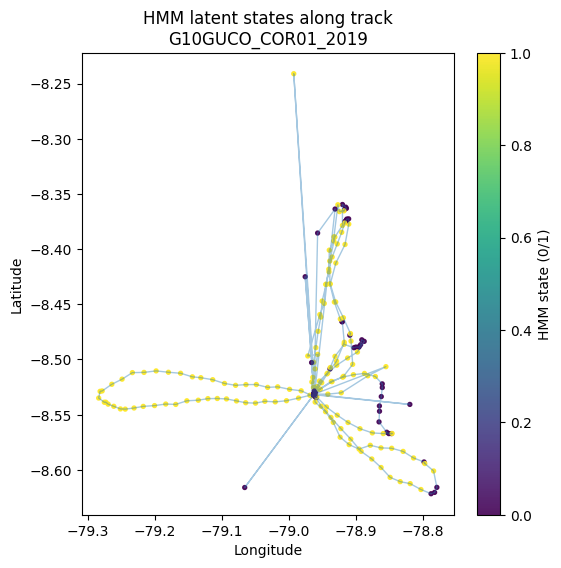

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# 先画灰色轨迹线（只表示路径）
plt.plot(g["location-long"], g["location-lat"], linewidth=1, alpha=0.4)

# 再画按 state 着色的点
sc = plt.scatter(
    g["location-long"], g["location-lat"],
    c=g["state"], s=8, alpha=0.9
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"HMM latent states along track\n{ind}")

cb = plt.colorbar(sc)
cb.set_label("HMM state (0/1)")

plt.show()

	•	轨迹上出现了连续成段的同色点（不是随机跳色），说明 HMM 学到了状态持续性（与你的转移矩阵一致：rest 很稳定，flight 也有持续性）。
	•	空间上，高状态（黄色）沿着更长、更连续的路径分布，低状态（紫色）更集中在某些位置附近，符合“飞行段 vs 停留/低速段”的直觉。

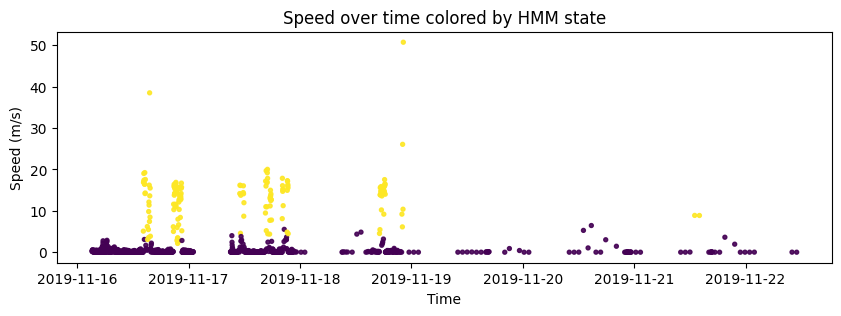

In [49]:
plt.figure(figsize=(10, 3))
plt.scatter(g["timestamp"], g["speed"], c=g["state"], s=8, alpha=0.9)
plt.xlabel("Time")
plt.ylabel("Speed (m/s)")
plt.title("Speed over time colored by HMM state")
plt.show()

	•	黄色点主要集中在更高速度区间（许多在 10–20 m/s，且偶有更高点），紫色点基本压在接近 0 的区域。
	•	这与我们之前的 state mean（\approx 0.10 m/s vs \approx 12.7 m/s）完全一致：状态解释自洽。

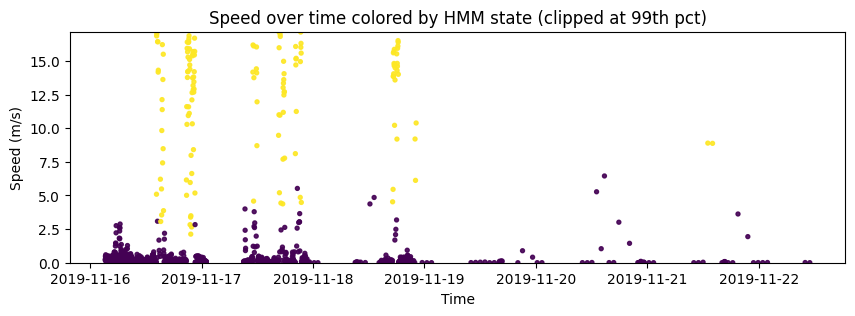

In [50]:
ymax = g["speed"].quantile(0.99)
plt.figure(figsize=(10,3))
plt.scatter(g["timestamp"], g["speed"], c=g["state"], s=8, alpha=0.9)
plt.ylim(0, ymax)
plt.xlabel("Time")
plt.ylabel("Speed (m/s)")
plt.title("Speed over time colored by HMM state (clipped at 99th pct)")
plt.show()

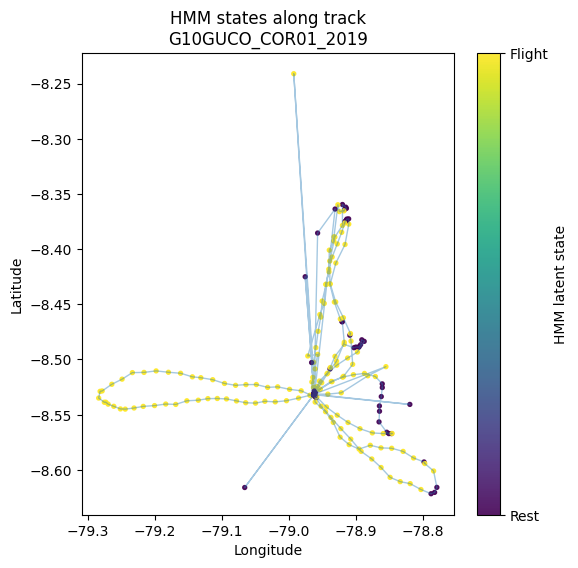

In [51]:
import matplotlib.ticker as mticker

plt.figure(figsize=(6,6))
plt.plot(g["location-long"], g["location-lat"], linewidth=1, alpha=0.4)
sc = plt.scatter(g["location-long"], g["location-lat"], c=g["state"], s=8, alpha=0.9)

cb = plt.colorbar(sc, ticks=[rest_state, flight_state])
cb.ax.set_yticklabels(["Rest", "Flight"])
cb.set_label("HMM latent state")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"HMM states along track\n{ind}")
plt.show()

In [52]:
import numpy as np
import pandas as pd

eps = 1e-3

def decode_hmm_states_per_row(df, hmm, group_col="individual-local-identifier",
                             time_col="timestamp", speed_col="speed"):
    """
    Return a copy of df with two new columns:
    - state: Viterbi-decoded HMM state (int)
    - x: log(speed+eps) used as observation
    Works by concatenating sequences and mapping back to original rows.
    """
    df2 = df.copy()
    df2 = df2.sort_values([group_col, time_col]).copy()

    # observation
    df2["x"] = np.log(df2[speed_col].to_numpy() + eps)

    X_list, lengths, idx_list = [], [], []
    for ind, g in df2.groupby(group_col):
        x = g["x"].to_numpy().reshape(-1, 1)
        if len(x) < 10:
            continue
        X_list.append(x)
        lengths.append(len(x))
        idx_list.append(g.index.to_numpy())

    X = np.vstack(X_list)
    idx = np.concatenate(idx_list)

    z = hmm.predict(X, lengths)  # Viterbi
    out = df2.copy()
    out.loc[idx, "state"] = z
    out["state"] = out["state"].astype("Int64")  # allow missing for very short sequences
    return out

test_hmm_z = decode_hmm_states_per_row(test_hmm, hmm)
test_hmm_z = test_hmm_z[test_hmm_z["state"].notna()].copy()
test_hmm_z["state"] = test_hmm_z["state"].astype(int)

# 加语义标签（可选）
test_hmm_z["state_name"] = np.where(test_hmm_z["state"] == flight_state, "Flight", "Rest")

test_hmm_z[["individual-local-identifier","timestamp","speed","dt","dist","state","state_name"]].head()

,individual-local-identifier,timestamp,speed,dt,dist,state,state_name
0,G05GUCO_09_20181126-070802,2018-11-25 14:20:59,15.224994,64.0,974.399597,1,Flight
1,G05GUCO_09_20181126-070802,2018-11-25 14:22:03,0.000000,64.0,0.000000,0,Rest
2,G05GUCO_09_20181126-070802,2018-11-25 14:24:28,0.891430,145.0,129.257299,0,Rest
3,G05GUCO_09_20181126-070802,2018-11-25 14:25:33,0.000000,65.0,0.000000,0,Rest
4,G05GUCO_09_20181126-070802,2018-11-25 14:26:45,1.129232,72.0,81.304724,0,Rest


In [53]:
def state_summary_table(df, state_col="state", speed_col="speed", x_col="x"):
    g = df.copy()

    # speed summary
    summary = g.groupby(state_col).agg(
        n=(speed_col, "size"),
        speed_mean=(speed_col, "mean"),
        speed_median=(speed_col, "median"),
        speed_p10=(speed_col, lambda s: s.quantile(0.10)),
        speed_p90=(speed_col, lambda s: s.quantile(0.90)),
        logspeed_mean=(x_col, "mean"),
    ).reset_index()

    # proportion
    total = summary["n"].sum()
    summary["prop"] = summary["n"] / total

    # typical speed from log-mean: exp(E[log v]) (geometric-ish typical)
    summary["typical_speed_from_logmean"] = np.exp(summary["logspeed_mean"])

    # add state name
    summary["state_name"] = np.where(summary[state_col] == flight_state, "Flight", "Rest")

    # nicer column order
    summary = summary[[
        "state_name", state_col, "n", "prop",
        "typical_speed_from_logmean",
        "speed_mean", "speed_median", "speed_p10", "speed_p90",
        "logspeed_mean"
    ]].sort_values(state_col)

    return summary

state_tbl = state_summary_table(test_hmm_z)
state_tbl

,state_name,state,n,prop,typical_speed_from_logmean,speed_mean,speed_median,speed_p10,speed_p90,logspeed_mean
0,Rest,0,7860,0.868988,0.091686,0.244700,0.087340,0.020386,0.494246,-2.389391
1,Flight,1,1185,0.131012,12.822777,13.898097,14.155899,7.139104,18.151012,2.551223


In [54]:
def bout_table_for_one_sequence(g, state_col="state", dt_col="dt"):
    """
    g must be sorted by time for one individual.
    Returns a DataFrame of bouts with columns:
    - state
    - n_steps
    - duration_s
    """
    z = g[state_col].to_numpy()
    dt = g[dt_col].to_numpy()

    # run-length encoding boundaries
    change = np.r_[True, z[1:] != z[:-1]]
    bout_id = np.cumsum(change) - 1

    bouts = []
    for b in np.unique(bout_id):
        idx = np.where(bout_id == b)[0]
        state = int(z[idx[0]])
        n_steps = len(idx)

        # duration: sum of dt for points inside the bout
        # dt[i] is time since previous point; for the first point of a bout, dt belongs to transition.
        # A reasonable approximation: sum dt over indices excluding the first index of the whole track if dt is NaN.
        dts = dt[idx]
        dts = dts[np.isfinite(dts)]
        duration_s = float(dts.sum())

        bouts.append((state, n_steps, duration_s))

    return pd.DataFrame(bouts, columns=["state", "n_steps", "duration_s"])

def bout_summary_table(df, group_col="individual-local-identifier", time_col="timestamp",
                       state_col="state", dt_col="dt"):
    df2 = df.sort_values([group_col, time_col]).copy()

    all_bouts = []
    for ind, g in df2.groupby(group_col):
        g = g.dropna(subset=[state_col]).copy()
        if len(g) < 10:
            continue
        bt = bout_table_for_one_sequence(g, state_col=state_col, dt_col=dt_col)
        bt[group_col] = ind
        all_bouts.append(bt)

    bouts = pd.concat(all_bouts, ignore_index=True)

    # aggregate per state
    out = bouts.groupby("state").agg(
        n_bouts=("n_steps", "size"),
        mean_steps=("n_steps", "mean"),
        median_steps=("n_steps", "median"),
        mean_duration_s=("duration_s", "mean"),
        median_duration_s=("duration_s", "median"),
    ).reset_index()

    out["mean_duration_min"] = out["mean_duration_s"] / 60.0
    out["median_duration_min"] = out["median_duration_s"] / 60.0
    out["state_name"] = np.where(out["state"] == flight_state, "Flight", "Rest")

    out = out[[
        "state_name","state","n_bouts",
        "mean_steps","median_steps",
        "mean_duration_min","median_duration_min"
    ]].sort_values("state")

    return out, bouts

bout_tbl, bouts_raw = bout_summary_table(test_hmm_z)
bout_tbl

,state_name,state,n_bouts,mean_steps,median_steps,mean_duration_min,median_duration_min
0,Rest,0,133,59.097744,9.0,179.548371,39.133333
1,Flight,1,126,9.404762,7.0,22.833730,19.000000


# Results + Discussion (最终版)

## Results（结果）

### 数据与预处理（Data & preprocessing）
我们使用 Movebank 海鸟 GPS 轨迹数据（经纬度 + 时间戳），对相邻定位点计算：
- 时间间隔：\(\Delta t\)（秒）
- 位移距离：\(\text{dist}\)（米）
- 速度：\(\text{speed}=\text{dist}/\Delta t\)（m/s）

为构建可解释的起始标签，我们采用运动学阈值定义伪标签：
\[
y_t =
\begin{cases}
1 & \text{if } \text{speed}_t \ge 2.5 \\
0 & \text{otherwise}
\end{cases}
\]
（其中 \(y_t=1\) 可解释为 flight，高速移动；\(y_t=0\) 可解释为 rest/low-speed。）

---

### 时间切分与“无泄漏”验证（Temporal split & leakage control）
为避免时间序列信息泄漏，我们对**每只鸟**在其自身时间轴上进行 70/30 的时间切分（过去→训练、未来→测试）。切分后样本量与类别比例为：

- 训练集：\(n=21145\)，其中 \(y=1\) 为 2284  
  \[
  \text{flying ratio}=\frac{2284}{21145}\approx 0.108016
  \]
- 测试集：\(n=9073\)，其中 \(y=1\) 为 1003  
  \[
  \text{flying ratio}=\frac{1003}{9073}\approx 0.110548
  \]

训练/测试 flying 比例非常接近（约 10.8% vs 11.1%），说明切分未引入灾难性分布偏移，同时保证两类在训练/测试中均存在，从而形成可学习、可评估的问题设置。

---

### 监督学习基线（Supervised baselines）

#### (1) 使用 \(\text{speed}, \text{dist}, \Delta t\) 的 Logistic Regression
在严格时间外推测试集上，Logistic Regression 达到：
- **Accuracy** = 0.993938  
- **ROC-AUC** = 0.999588  
- **Confusion matrix** =
\[
\begin{pmatrix}
8046 & 24\\
31 & 972
\end{pmatrix}
\]

该结果非常高，主要原因是伪标签本身由 speed 阈值定义，而 speed 同时作为输入特征，模型几乎在复现阈值规则（label–feature circularity）。

#### (2) 移除 speed，仅用 \(\text{dist}, \Delta t\) 重新建模
移除 speed 后模型仍表现良好：
- **Accuracy** = 0.968478  
- **ROC-AUC** = 0.980364  
- **Confusion matrix** =
\[
\begin{pmatrix}
7867 & 203\\
83 & 920
\end{pmatrix}
\]

模型系数方向为 dist 正、dt 负（dist: +3.048, dt: −23.820），与“短时间内位移越大越像飞行”的物理直觉一致。

---

### Sanity checks：解释高分的统计原因（Why is AUC still high without speed?）
为解释“去掉 speed 仍高 AUC”的原因，我们进行了两项检查：

1) 绘制 \(\text{dist}\)–\(\Delta t\) 散点并叠加阈值线 \(\text{dist}=2.5\Delta t\)。可见高速段在该平面上具有明显可分结构。  
2) 单变量模型对比：
- **AUC(dist only)** = 0.970460  
- **AUC(dt only)** = 0.527114（接近随机）

这说明高性能主要来自 \(\text{dist}\) 与伪标签（本质上由 \(\text{dist}/\Delta t\) 决定）之间的强一致性；该结果对 pipeline 验证很有价值，但也提示该任务在当前标签定义下具有“规则可恢复”的性质。

---

### 无监督/半监督升级：2 状态 Gaussian HMM（Hidden Markov Model）
为避免仅复现阈值规则，我们进一步采用 2 状态高斯 HMM 对序列进行隐状态建模。观测量定义为：
\[
x_t=\log(\text{speed}_t+\varepsilon),\quad \varepsilon=10^{-3}
\]
并在训练集上拟合 HMM，在测试集上用 Viterbi 解码得到隐状态序列。

HMM 学到的两个状态在 log-speed 均值上明显分离：
- \(\mu_{\text{rest}}=-2.317762\)
- \(\mu_{\text{flight}}=2.540632\)

将均值从 log-speed 转回速度尺度（近似 \(v\approx e^\mu\)）：

- Rest 状态：
\[
v_{\text{rest}}\approx e^{-2.317762}
= e^{-2}\cdot e^{-0.317762}
\approx 0.1353\times 0.727 \approx 0.098\ \text{m/s}
\]
- Flight 状态：
\[
v_{\text{flight}}\approx e^{2.540632}
= e^{2.5}\cdot e^{0.040632}
\approx 12.182\times 1.041 \approx 12.7\ \text{m/s}
\]

转移矩阵为：
\[
A=
\begin{pmatrix}
0.983946 & 0.016054\\
0.115318 & 0.884682
\end{pmatrix}
\]
显示 resting 状态高度持久（\(P(r\to r)\approx0.984\)），flight 状态也具有持续性（\(P(f\to f)\approx0.885\)），符合行为“段落化”的直觉。

作为 sanity check（非严格真值），将 HMM 的 flight 状态与阈值伪标签对齐，得到：
- 总体 accuracy = 0.965  
- flying 类 precision = 0.787，recall = 0.932  

这反映 HMM 能恢复高速状态并进行时间平滑：倾向将边界点归入连贯的飞行段，从而提高召回率但略降低精确率。

---

### 可视化结果（Visualization）
轨迹着色图显示隐状态在空间上呈现连续段落而非随机跳变；速度-时间图中，高速状态对应明显更高的速度云团，进一步支持“隐状态≈行为段”的解释。

---

## Discussion（讨论）

### 主要发现与意义（Key findings）
1) **严格时间外推评估 + 稳定类分布** 验证了 pipeline 的正确性，避免时间泄漏导致的虚高分数。  
2) Logistic Regression 在伪标签任务上达到极高 AUC，说明该伪标签在观测特征空间中高度可恢复；这对工程验证与方法基线有价值，但不能直接等价于“真实行为识别”。  
3) HMM 在不依赖阈值标签训练的条件下，从 log-speed 序列中自动发现了两个速度尺度显著不同的隐状态，并学习到合理的状态持续性与转移结构，提供了更接近“行为段落推断”的 AI 输出（状态序列 + 转移动力学）。

### 局限性（Limitations）
- 监督任务使用阈值伪标签，本质上由 \(\text{dist}/\Delta t\) 决定，监督模型的高分主要反映“规则可恢复”，而非完全独立的行为真值。  
- GPS 误差、采样间隔不均与偶发跳点可能造成极端速度值，影响速度分布尾部与边界点归类。  
- HMM 目前仅使用 1 维观测（log-speed），尚未结合转向角、加速度、环境协变量等更丰富的行为线索。

### 未来工作（Future work）
- 采用连续段标签（window/segment label）或更复杂的行为定义，减少单点阈值可恢复性。  
- 引入轨迹几何特征（turning angle、acceleration、residence time）作为 HMM/序列模型观测，提高对“觅食/盘旋/通勤”等中间状态的区分。  
- 尝试 3 状态 HMM，并用 BIC/对数似然对比选择模型复杂度，探索 rest/commute/flight 的更细粒度结构。  
- 若能获得独立行为注释或多传感器数据（如加速度计），可进行更严格的外部验证与监督学习建模。

---

## English Summary (Optional)

### Results
We derived \(\Delta t\), displacement (dist), and speed from Movebank GPS tracks, and created pseudo-labels \(y=\mathbb{1}[\text{speed}\ge2.5]\). Using an individual-wise temporal split (70/30), class ratios remained stable (train ≈0.108, test ≈0.111), supporting leakage-free evaluation. A logistic regression baseline achieved extremely high AUC when speed was included (AUC≈0.9996), consistent with label–feature circularity. Removing speed still yielded strong performance (AUC≈0.9804), explained by the strong recoverability of the threshold in the (dist, dt) plane (AUC(dist only)≈0.970; AUC(dt only)≈0.527). A 2-state Gaussian HMM on \(x=\log(\text{speed}+\varepsilon)\) discovered two well-separated latent states with means corresponding to ≈0.10 m/s and ≈12.7 m/s, and a persistent transition structure (rest more stable than flight), producing coherent bouts along the track.

### Discussion
The temporal split validates a leakage-free pipeline. High supervised performance largely reflects recoverability of threshold-based pseudo-labels, whereas the HMM provides unsupervised latent-state discovery, interpretable transition dynamics, and temporally coherent behavioral segmentation. Future work includes segment-based labels, richer movement features, and model selection for multi-state HMMs, ideally validated by independent annotations or multi-sensor data.